# Position of the Telescope in the Dome

In [1]:
%matplotlib notebook
import numpy as np
import numpy.linalg as la

# Plotting
import ipywidgets as widgets
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# from pytransform3d.transformations import transform_from, plot_transform
# from pytransform3d.rotations import random_axis_angle, matrix_from_axis_angle

# For astro conversions
from astropy.coordinates import EarthLocation
from astropy.time import Time
from astropy import units as u
import datetime

## Modelling The Telescope Pointing

Relevant dimensions/constants (in meters unless otherwise stated):

In [2]:
# Telescope:
l_1 = 0.806 # distance floor-HA axis
l_2 = 1.326 # distance HA axis-Dec axis
l_3 = 0.424 # distance Dec axis-tube center

aperture_r = 0.2 # m

# Dome:
d = 6.5   # diameter
r = d/2   # radius
e = 1.76  # extent of cylindrical dome wall
h = r + e # height of half capsule repr. dome
w = 1.84  # Slit width

# Obvervatory:
lat = 53.24 # degrees

Defining the transformation matrices:

In [3]:
def vec(x, y, z):
    return np.array([x, y, z, 1]) #np.array([x, y, z, 1]).reshape((4,1))

def trans(x, y, z):
    return np.array([
        [1, 0, 0, x],
        [0, 1, 0, y],
        [0, 0, 1, z],
        [0, 0, 0, 1],
    ])

def rot_x(angle):
    angle = np.radians(angle)
    return np.array([
        [1,             0,              0, 0],
        [0, np.cos(angle), -np.sin(angle), 0],
        [0, np.sin(angle),  np.cos(angle), 0],
        [0,             0,              0, 1],
    ])

def rot_y(angle):
    angle = np.radians(angle)
    return np.array([
        [np.cos(angle),  0,  -np.sin(angle), 0],
        [0,              1,               0, 0],
        [-np.sin(angle), 0,   np.cos(angle), 0],
        [0,              0,               0, 1],
    ])

def rot_z(angle):
    angle = np.radians(angle)
    return np.array([
        [np.cos(angle),  -np.sin(angle), 0, 0],
        [np.sin(angle),  np.cos(angle), 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1],
    ])

Compute the position of the telescope back plate with `get_transform` and `telescope_pos`.

In [4]:
def get_transform(ha, dec, y_back=-0.5):
    H_01 = trans(0, 0, l_1)
    H_12 = rot_x(90-lat) @ rot_z(-ha) @ trans(0, 0, l_2)
    H_23 = rot_x(dec) @ trans(-l_3, 0, 0)
    H_34 = trans(0, y_back, 0)
    
    H = H_01 @ H_12 @ H_23 @ H_34
    
    return H

def telescope_pos(ha=0, dec=0):
    origin = vec(0, 0, 0)
    print(ha, dec)
    pose_matrix = get_transform(ha, dec)
    
    return pose_matrix @ origin

In [5]:
# ha_tmp = -45
# dec_tmp = 0

# # NEW COMPUTATION
# dv = ((get_transform(ha_tmp, dec_tmp, y_back=1) - get_transform(ha_tmp, dec_tmp, y_back=0)) @ np.array([0, 0, 0, 1]))[:3]

# print(dv, 'with length =', la.norm(dv))

# os = get_origins(ha_tmp, dec_tmp)[:,:3].reshape(6, 3)
    
# # OLD COMPUTATION
# tube_center = os[[3,5]][0]
# direction = Vector(*get_direction(tube_center, os[[3,5]][1]))

# print(direction.get_array(), 'with length =', direction.get_norm())

## Telescope in dome frame

Compute the origin of each consecutive reference frame with `get_origins`.

In [6]:
def get_origins(ha, dec, y_back=-0.3):
    """Compute the origin of each intermediate ref. frame."""
    origin = vec(0, 0, 0)
    H_01 = trans(0, 0, l_1)
    H_12 = rot_x(90-lat) @ rot_z(-ha) @ trans(0, 0, l_2)
    H_23 = rot_x(dec) @ trans(-l_3, 0, 0)
    H_34 = trans(0, y_back, 0)
    H_45 = trans(0, -3*y_back, 0)
    
    pose_0 = origin # Dome origin
    pose_1 = H_01 @ origin # RA axis origin
    pose_2 = H_01 @ H_12 @ origin # Dec axis origin
    pose_3 = H_01 @ H_12 @ H_23 @ origin # Center aperture
    pose_4 = H_01 @ H_12 @ H_23 @ H_34 @ origin # Back aperture
    pose_5 = H_01 @ H_12 @ H_23 @ H_34 @ H_45 @ origin # Front aperture

    return np.array([pose_0, pose_1,pose_2,pose_3,pose_4, pose_5])

def get_direction(p1, p2):
    d = p2 - p1
    d_unit = d/la.norm(d)
    
    return d_unit

(Interactivelly) plot the resulting *telescope + mount* assembly. Note, to draw the dome, we need the following two functions to generate some vertices:

In [7]:
def get_cylinder(center_x, center_y, radius, height_z):
    z = np.linspace(0, height_z, 10)
    
    theta = np.linspace(0, 2*np.pi, 20)
    theta_grid, z_grid = np.meshgrid(theta, z)
    
    x_grid = radius*np.cos(theta_grid) + center_x
    y_grid = radius*np.sin(theta_grid) + center_y
    
    return x_grid, y_grid, z_grid

def get_hemisphere(r=1, center_x=0, center_y=0, center_z=0):
    u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi/2:10j]
    
    x = r * np.cos(u) * np.sin(v) + center_x
    y = r * np.sin(u) * np.sin(v) + center_y
    z = r * np.cos(v) + center_z
    
    return x, y, z

def get_dome_slit_arc(az=0,r=1, center_x=0, center_y=0, center_z=0):
    u = az + np.pi/2
    v = np.mgrid[0:np.pi/2:10j]
    
    x = r * np.cos(u) * np.sin(v) + center_x
    y = r * np.sin(u) * np.sin(v) + center_y
    z = r * np.cos(v) + center_z
    
    return x, y, z

def get_dome_slit_surface(az=0, width=1, r=1, center_x=0, center_y=0, center_z=0):
    x = np.linspace(-width/2, width/2, 10) + center_x
    
    theta = np.linspace(-np.pi/10, np.pi/2, 20)
#     theta = np.linspace(0, 2*np.pi, 20)
    theta_grid, x_grid = np.meshgrid(theta, x)
    
    y_grid = r*np.sin(theta_grid) + center_y
    z_grid = r*np.cos(theta_grid) + center_z
    
#     x_grid = x_grid * np.cos(az) - y_grid * np.sin(az)
#     y_grid = x_grid * np.sin(az) + y_grid * np.cos(az)
    
    return x_grid, y_grid, z_grid

To calculate the dome azimuth, using `atan2`, we require a conversion function. Assuming we assume the azimuth to be 0 north and increasing in the eastward direction.

In [8]:
def compute_azimuth(x, y):
    """
    Return the azimuth (rad) using
    the north clockwise conv.
    """
    az = np.arctan2(x, y) # note (x,y) rather than (y,x)
    
    if az < 0:
        az += 2*np.pi
    
    return az

## Dome Azimuth

In [9]:
class Capsule:
    def __init__(self, radius, extent, center_x=0, center_y=0, center_z=0):
        self.r = radius
        self.e = extent
        self.c = np.array([center_x, center_y, center_z])
        
    def get_radius(self):
        return self.r
    
    def get_extent(self):
        return self.e
    
    def get_center(self):
        return self.c
    
class Vector:
    def __init__(self, x=0, y=0, z=0):
        self.x = x
        self.y = y
        self.z = z
        self.array = np.array([x, y, z])
        
    def get_x(self):
        return self.x
        
    def get_y(self):
        return self.y
        
    def get_z(self):
        return self.z
    
    def get_array(self):
        return self.array
    
    def get_norm(self):
        return la.norm(self.get_array())

In [10]:
# dome      = Capsule(r, e)
# direction = Vector(0, 0, -0.1)
# p         = Vector(1, 1, 1)

In [11]:
def find_intersection(point, direction, capsule):
    has_intersection = False
    t = None
    
#     if direction.z < 0:
#         return has_intersection, t
    
    if np.isclose(direction.x, 0) and np.isclose(direction.y, 0):
        z = e + np.sqrt(capsule.r**2 - point.x**2 - point.y**2)
        t = z - point.z
        
        has_intersection = True
        return has_intersection, t
    
    # If the direction vector is not (nearly) parallel to 
    # the z-axis of the capsule
    a2 = direction.x**2 + direction.y**2
    a1 = point.x*direction.x + point.y*direction.y
    a0 = point.x**2 + point.y**2 - capsule.r**2
    
    delta = a1**2-a0*a2
    t     = (-a1+np.sqrt(delta))/a2
    
    if point.z + t * direction.z >= capsule.e:
        a0 = point.x**2 + point.y**2 + (point.z-capsule.e)**2 - capsule.r**2
        a1 = point.x*direction.x + point.y*direction.y + (point.z-capsule.e)*direction.z
        
        t = -a1+np.sqrt(a1**2-a0)
    
    if t:
        has_intersection = True
    
    return has_intersection, t

def get_ray_intersection(p, d, t):
    return p.get_array() + t*d.get_array()

## Telescope-Dome Model

**Note:** To use the nort-clockwise convension to calculate the azimuth angle, use `atan2(x, y)` rather than `atan2(y, x)`, which gives the angle in an east-counterclockwise manner.

<IPython.core.display.Javascript object>


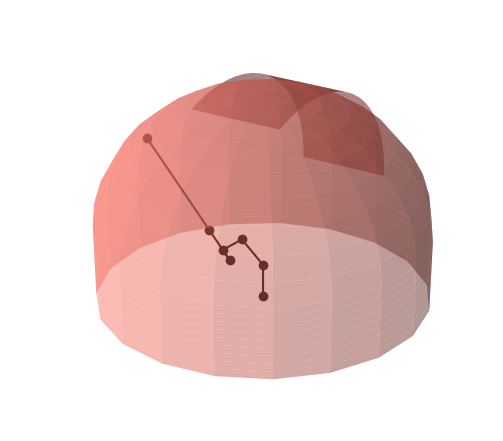

interactive(children=(FloatSlider(value=0.0, description='ha', max=180.0, min=-180.0, step=0.5), FloatSlider(v…

In [16]:
fig = plt.figure(figsize=(7, 7))
frame = fig.add_subplot(1, 1, 1, projection ='3d')

frame.grid(True, alpha=0.5)
frame.set_xlim(-2, 2)
frame.set_ylim(-2, 2)
frame.set_zlim(0, 4)

frame.set_xlabel('x')
frame.set_ylabel('y')
frame.set_zlabel('z')

dome  = Capsule(r, e)
walls = None
hemi  = None
slit  = None
dome_az = 0

@widgets.interact(ha=(-180, 180, 0.5), dec=(-90, 90, 0.5), has_dome=True, has_axes=False)
def update(ha=0, dec=0, has_dome=True, has_axes=False):
    """
    Update a graph of the dome-telescope system based on 
    the IPyWidget's input...
    """
    [l.remove() for l in frame.lines] # Remove the old lines, every time an input gets adjusted
    
    global walls
    global hemi
    global slit
    old_walls = walls
    old_hemi  = hemi
    old_slit  = slit
    
    # Get the origins of each ref. frame 
    os = get_origins(ha, dec)[:,:3].reshape(6, 3)
    
    # Compute dome intersection
    tube_center = (get_transform(ha, dec, y_back=0) @ vec(0, 0, 0))[:3] #os[[3,5]][0]
    dv = ((get_transform(ha, dec, y_back=1) - get_transform(ha, dec, y_back=0)) @ vec(0, 0, 0))[:3]
    direction = Vector(*dv) #Vector(*get_direction(tube_center, os[[3,5]][1]))
    
    p = Vector(*tube_center)
    
    try:
        has_intersection, t = find_intersection(p, direction, dome)
        
        if has_intersection:
            p_s = get_ray_intersection(p, direction, t)
            os = np.concatenate([os, [p_s]])
            
            dome_az = compute_azimuth(p_s[0], p_s[1])
            print('Az =', np.degrees(dome_az),'degrees')
    except:
        pass
    
    # Plot telescope + boresight
    scope = frame.plot3D(os[:,0], os[:,1], os[:,2], marker='o', color='black')
    
    # Plot dome orientation

    if has_dome:
        # Plot (cylindrical) dome walls
        x_c, y_c, z_c = get_cylinder(0, 0, dome.r, dome.e)
        walls = frame.plot_surface(x_c, y_c, z_c, alpha=0.5, color='xkcd:salmon')
        
        # Plot hemispherical dome
        x_s, y_s, z_s = get_hemisphere(r=dome.r, center_z=dome.e)
        hemi = frame.plot_surface(x_s, y_s, z_s, alpha=0.5, color='xkcd:salmon')
        
        # Plot slit
        x_sc, y_sc, z_sc = get_dome_slit_surface(az=dome_az, width=w, r=dome.r, center_z=dome.e)
        slit = frame.plot_surface(x_sc, y_sc, z_sc, alpha=0.5, color='xkcd:dark red')
        
    # Clear the 3D polygons
    if old_walls or old_hemi or old_slit:
        try:
            frame.collections.remove(old_walls)
            frame.collections.remove(old_hemi)
            frame.collections.remove(old_slit)
        except:
            pass
        
    # Toggle axes
    if has_axes:
        frame.set_axis_on()
    else:
        frame.set_axis_off()

## Polar graph

In [13]:
# fig, frame = plt.subplots(subplot_kw={'projection': 'polar'})
# r = np.arange(0, 2, 0.01)

# # ax.set_rmax(5)
# frame.grid(True)
# frame.set_theta_zero_location("N")

# frame.scatter(np.pi/2, 1)

# frame.set_title("A line plot on a polar axis", va='bottom')
# plt.show()

In [14]:
# import numpy as np
# import matplotlib.pyplot as plt
# from pytransform3d.transformations import transform_from, plot_transform
# from pytransform3d.rotations import random_axis_angle, matrix_from_axis_angle
# from pytransform3d.plot_utils import plot_cylinder, remove_frame

# A2B = transform_from(
#     R=matrix_from_axis_angle(np.array([1, 0, 0, np.pi/2])),
#     p=np.array([0,0,0]))

# B2C = transform_from(
#     R=matrix_from_axis_angle(np.array([0, 0, 1, 1.4*np.pi/2])),
#     p=np.array([0,0,0]))

# A2C = concat(A2B, B2C)


# ax = plot_cylinder(length=1.0, radius=0.3, thickness=0,
#                    wireframe=False, alpha=0)

# plot_transform(A2B=A2C)

# plot_cylinder(ax=ax, length=1.0, radius=0.3, thickness=0, A2B=A2C,
#               wireframe=False, alpha=0.2)

# ax.set_xlim((-1.5, 1.5))
# ax.set_ylim((-1.5, 1.5))
# ax.set_zlim((-0.8, 0.7))
# plt.show()

In [15]:
@widgets.interact(ha=(-180, 180, 0.5), dec=(-90, 90, 0.5))
def update(ha=0, dec=0):
    # NEW COMPUTATION
    dv = ((get_transform(ha, dec, y_back=1) - get_transform(ha, dec, y_back=0)) @ np.array([0, 0, 0, 1]))[:3]
    
    print('NEW:', dv, 'with length =', la.norm(dv))
    print('TC', (get_transform(ha, dec, y_back=0) @ np.array([0, 0, 0, 1]))[:3])

    os = get_origins(ha, dec)[:,:3].reshape(6, 3)

    # OLD COMPUTATION
    tube_center = os[[3,5]][0]
    
    direction = Vector(*get_direction(tube_center, os[[3,5]][1]))

    print('OLD:', direction.get_array(), 'with length =', direction.get_norm())
    print('TC', tube_center)

interactive(children=(FloatSlider(value=0.0, description='ha', max=180.0, min=-180.0, step=0.5), FloatSlider(v…